In [ ]:
# Hyperparameters
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 10
PATCH_SIZE = 7  # 7x7 patches
IMG_SIZE = 28   # MNIST images are 28x28

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define ViT Model
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # Flatten patches
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        x = x.transpose(0, 1)  # Required for nn.MultiheadAttention
        x, _ = self.attn(x, x, x)
        return x.transpose(0, 1)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128, num_heads=8, num_layers=6, mlp_dim=256, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.encoder = nn.Sequential(*[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, _ = x.shape
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # Prepend CLS token
        x = x + self.pos_embed
        x = self.encoder(x)
        x = self.norm(x[:, 0])  # Take CLS token output
        return self.head(x)



In [6]:
# Training Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



100.0%
100.0%
100.0%
100.0%


In [7]:
# Training and Validation Loop
num_epochs = 10
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(trainloader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(testloader)
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/10] - Train Loss: 0.3158, Train Acc: 0.8998, Val Loss: 0.1266, Val Acc: 0.9589
Epoch [2/10] - Train Loss: 0.1201, Train Acc: 0.9625, Val Loss: 0.0970, Val Acc: 0.9700
Epoch [3/10] - Train Loss: 0.1010, Train Acc: 0.9695, Val Loss: 0.0874, Val Acc: 0.9748
Epoch [4/10] - Train Loss: 0.0914, Train Acc: 0.9710, Val Loss: 0.0987, Val Acc: 0.9679
Epoch [5/10] - Train Loss: 0.0801, Train Acc: 0.9755, Val Loss: 0.0810, Val Acc: 0.9761
Epoch [6/10] - Train Loss: 0.0732, Train Acc: 0.9774, Val Loss: 0.0643, Val Acc: 0.9813
Epoch [7/10] - Train Loss: 0.0670, Train Acc: 0.9788, Val Loss: 0.0720, Val Acc: 0.9787
Epoch [8/10] - Train Loss: 0.0631, Train Acc: 0.9794, Val Loss: 0.0756, Val Acc: 0.9766
Epoch [9/10] - Train Loss: 0.0603, Train Acc: 0.9800, Val Loss: 0.0787, Val Acc: 0.9771
Epoch [10/10] - Train Loss: 0.0547, Train Acc: 0.9827, Val Loss: 0.0643, Val Acc: 0.9802


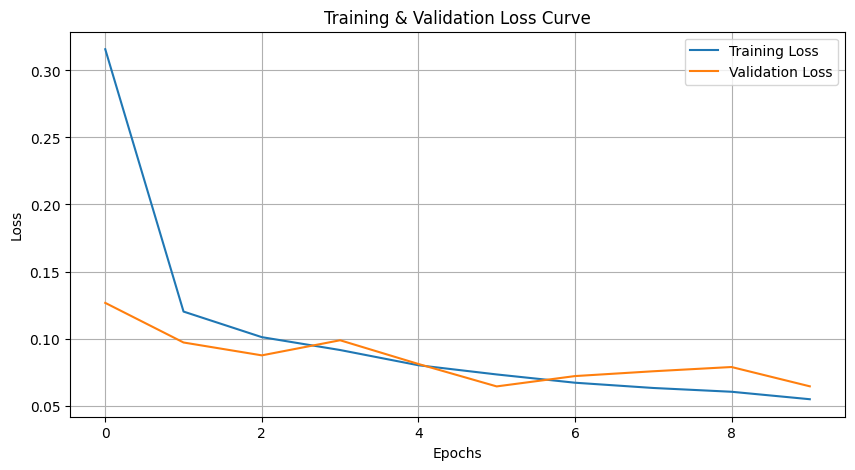

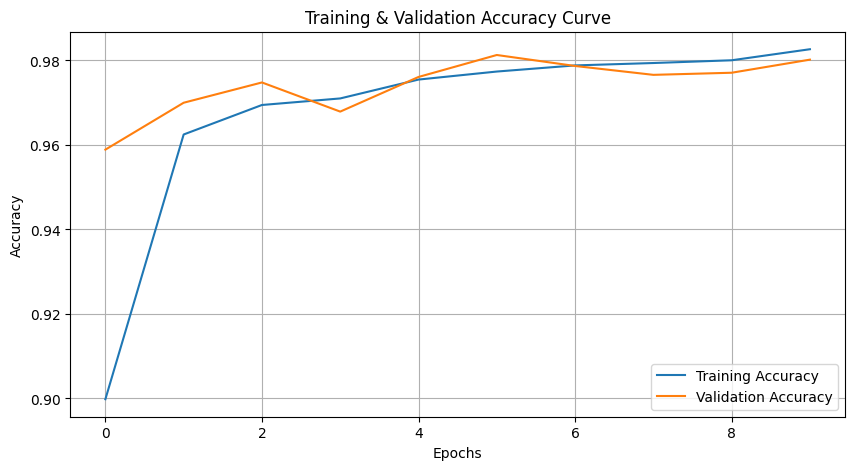

In [8]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Curve")
plt.legend()
plt.grid()
plt.show()


In [9]:
# Define the file name
model_path = "vit_mnist.pth"

# Save the trained model
torch.save(model.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at vit_mnist.pth


In [ ]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 128, kernel_size=(7, 7), stride=(7, 7))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (attn): MultiheadAttention(
         

In [14]:
from PIL import Image
# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure it's grayscale
    transforms.Resize((28, 28)),  # Resize to match MNIST dimensions
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Load and preprocess the image
image_path = "testSet/img_1.jpg"  # Update with the actual path
image = Image.open(image_path)  # Open the image
image = transform(image)  # Apply transformations
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device


In [15]:
# Perform inference
with torch.no_grad():
    output = model(image)  # Get model predictions
    predicted_class = torch.argmax(output, dim=1).item()  # Get the class with max probability

print(f"Predicted digit: {predicted_class}")


Predicted digit: 2


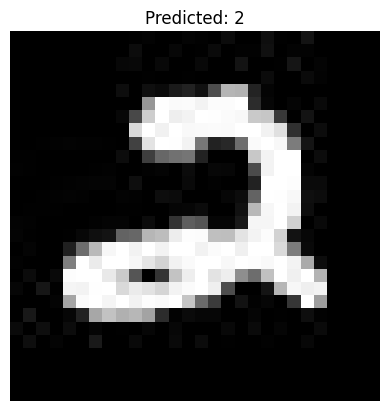

In [16]:
import matplotlib.pyplot as plt

plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()
